This notebook contains the source code for salty. Usage examples are below

<a id='top'></a>

# Contents

[load datasets](#load datasets)

[create histogram of selected features](#histogram)

[train lasso](#lasso)

[train multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

#grab our checkName code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import salty

<a id='load datasets'></a>

# Load datasets

[back to top](#top)

In [32]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)

datadf_dropped = datadf.dropna(inplace=False) #remove rows with NaN 
print("dropped nan rows: %s" % (datadf.shape[0]-datadf_dropped.shape[0]))
datadf = datadf_dropped

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
saltlist = datadf['salt_name']
density = datadf['density']

datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)
datadf = datadf.drop('density',1)

cols = data.columns.tolist()



data=np.array(datadf)

#scale and center data
data = StandardScaler().fit_transform(data.iloc[:,:])

data = pd.DataFrame(data, columns=cols[:])
data.loc[:,'density'] = pd.Series(viscosity)
data.loc[:,'NAME_CAT'] = pd.Series(catlist)
data.loc[:,'NAME_ANI'] = pd.Series(anilist)

datadf.to_pickle('density_centered_scaled')

dropped nan rows: 103
(7255, 190)
(1814, 190)


In [37]:
alpha_array=np.arange(0.02,0,-1e-3)
avg, std, results = salty.validationWrapper(name_of_pickle="density_centered_scaled", \
            BSF=0.8, alpha_array=alpha_array, iterations=\
            10, invisible_test=False, method="bootstrap")

performing iteration 1 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 2 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 3 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 4 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 5 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 6 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 7 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 8 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 9 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete
performing iteration 10 of 10
running bootstrap
Job will perform 20 tests for lambda
Job complete


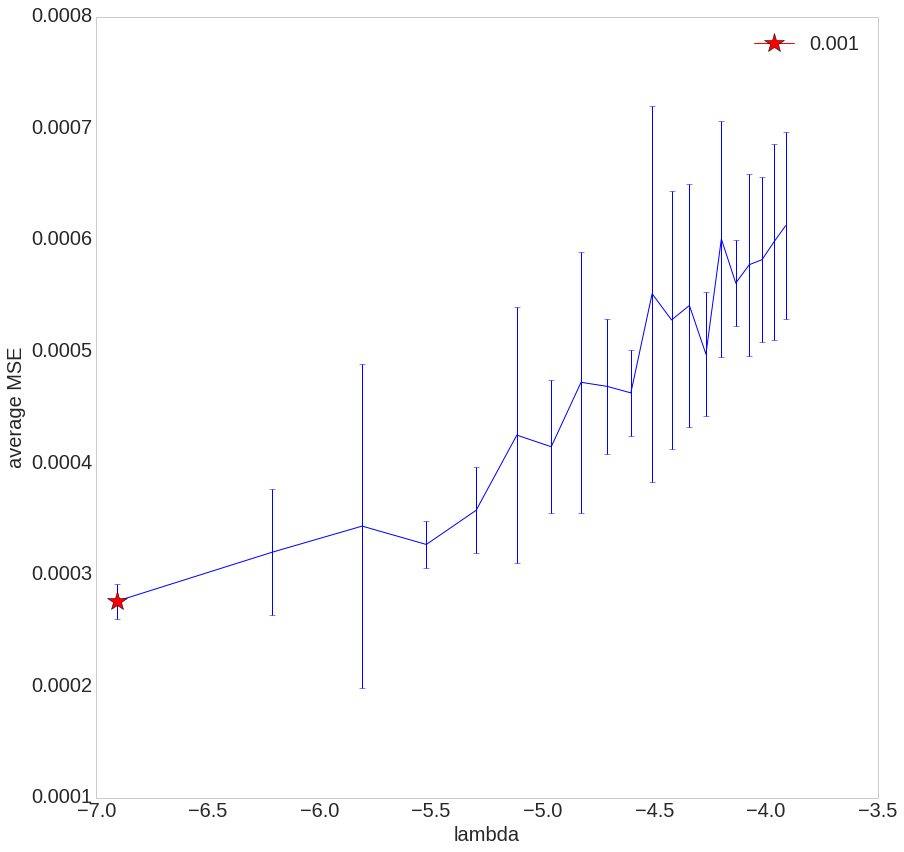

In [39]:
salty.displayResult(alpha_array, avg, variances=std, error=True)

<a id='ci_coeff'></a>

# Find Confidence Intervals for LASSO Coefficients

[back to top](#top)

In [ ]:
###bootstrap coefficients
iterations=1000
averages=np.zeros(iterations)
variances=np.zeros(iterations)
test_MSE_array=[]
###load data
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
datadf_dropped = datadf.dropna(inplace=False) #remove empty columns and rows with NaN 
print("dropped nan rows: %s" % (datadf.shape[0]-datadf_dropped.shape[0]))
datadf = datadf_dropped
datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)
           
data=np.array(datadf)
data_scaled = StandardScaler().fit_transform(datadf.iloc[:,:-1])

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_trainc
deslist=datadf.columns
score=np.zeros(len(datadf.columns))
feature_coefficients=np.zeros((len(datadf.columns),iterations))
test_MSE_array=[]

for i in range(iterations):
    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))

    ###sample from training set with replacement
    for k in range(n_train):
        x = randint(0,n_train)
        X_train[k] = data[x,:-1]
        Y_train[k] = np.log(float(data[x,-1]))
    n = data.shape[0]
    ###sample from test set with replacement
    for k in range(n_test):
        x = randint(n_train,n)
        X_test[k] = data[x,:-1]
        Y_test[k] = np.log(float(data[x,-1]))

    ###train the lasso model    
    model = Lasso(alpha=0.021,tol=1e-10,max_iter=4000)
    model.fit(X_train,Y_train)
    
    ###Check what features are selected
    p=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            feature_coefficients[a,i] = model.coef_[a] ###append the model coefs 
            p+=1
    avg_size.append(p)
    
    ###Calculate the test set MSE
    Y_hat = model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
print(np.average(avg_size))
print(np.average(test_MSE_array))
print(np.std(test_MSE_array))
select_score=[]
select_deslist=[]
feature_coefficient_averages=[]
feature_coefficient_variance=[]
feature_coefficients_all=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])
        feature_coefficient_averages.append(np.average(feature_coefficients[a,:]))
        feature_coefficient_variance.append(np.std(feature_coefficients[a,:]))
        feature_coefficients_all.append(feature_coefficients[a,:])

<a id='lasso'></a>

# Train LASSO

[back to top](#top)

In [4]:
model = Lasso(alpha=0.001,tol=1e-10, max_iter=4000)
model.fit(X_train,Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=4000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-10, warm_start=False)

In [40]:
f = open('../salty/data/Deslist','r')
deslist = []
for line in f:
    deslist.append(line.strip('\n\t'))
cols_cat = [s + "-cation" for s in deslist]
cols_ani = [s + "-anion" for s in deslist]
deslist = cols_cat + cols_ani + ["Temperature_K" , "Pressure_kPa", "Density_kg/m"]

i=0
for a in range(len(deslist)-3):
    if model.coef_[a] != 0:
        print(a, deslist[a])
        i+=1
print(i)

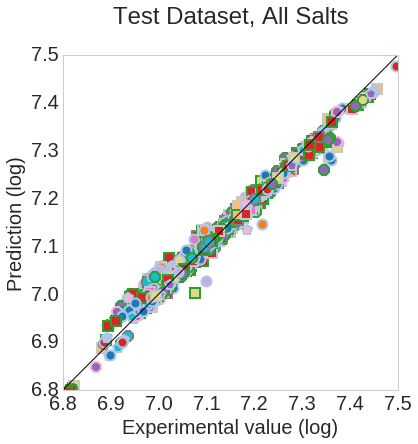

In [41]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        catIndex = salty.checkName(catlist[i],index=True)[1]
        aniIndex = salty.checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(6.8,7.5,0.0001),np.arange(6.8,7.5,0.0001),color = 'black')
    ax2.axis([6.8,7.5,6.8,7.5])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/Test_Dataset_All_Salts.eps'\
            , bbox_inches='tight', format='eps')    

In [ ]:
["Temperature_K" , "Pressure_kPa", "Density_kg/m"]
X=Y_test
Y=model.predict(X_test)
to_save=pd.DataFrame(np.transpose([X,Y,labels,T,P]),columns=["Density_kg/m, Experimental",\
        "Density_kg/m, Prediction", "Salt Name", "Temperature_K" , "Pressure_kPa"])

In [ ]:
pd.DataFrame.to_csv(to_save, path_or_buf='../salty/data/data_2_d3_Press_Temp.csv', index=False)

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [5]:
####Create dataset according to LASSO selected features
select_score = np.load("LASSOSelectionScoresAllSalts.npy")
select_deslist = np.load("LASSOSelectionListAllSalts.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
avg_selected_features=34
df = df.iloc[:avg_selected_features]

datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
atadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 
# datadf = datadf.loc[datadf["NAME_CAT"] != "1-ethyl-3-methylimidazolium"] #create subset

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)

to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
to_add.append("Density_kg/m")
cols = [col for col in datadf.columns if col in to_add]
data = datadf[cols]
        

data=np.array(data)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))


In [6]:
###optimization w/ 100 nodes in hidden layer
model = MLPRegressor(activation='tanh', alpha=0.00001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=100000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

model.fit(X_train,Y_train)

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=100000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

user has queried with a name
your query has returned CCN1C=C[N+](=C1)C
user has queried with a name
your query has returned [B-](F)(F)(F)F
user has queried with a name
your query has returned CCN1C=C[N+](=C1)C
user has queried with a name
your query has returned F[P-](F)(F)(F)(F)F
user has queried with a name
your query has returned CCCCCCN1C=C[N+](=C1)C
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCN1C=C[N+](=C1)C
user has queried with a name
your query has returned C(#N)[N-]C#N
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has

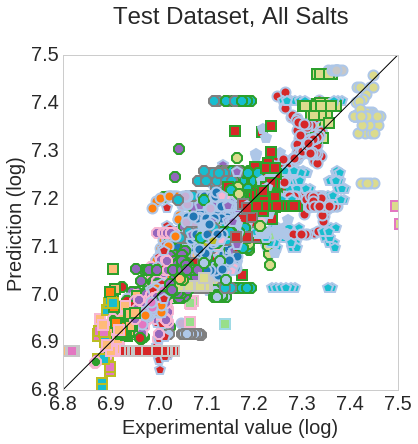

In [7]:
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_train)):
        catIndex = salty.checkName(catlist[i],index=True)[1]
        aniIndex = salty.checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_train)):
        ax2.plot(Y_train[i],model.predict(X_train[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(6.8,7.5,0.0001),np.arange(6.8,7.5,0.0001),color = 'black')
    ax2.axis([6.8,7.5,6.8,7.5])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()

fig.savefig(filename='../webapp/salty_web_app/collection/static/images/NN_Test_Dataset_All_Salts.eps', bbox_inches='tight', format='eps')    

<a id='static'></a>

# Create static files

[back to top](#top)

In [50]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 

def createArrays(datadf):
    data=np.array(datadf)
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*0.8)
    n_test  = n - n_train
    data = np.random.permutation(data)
    X_train = np.zeros((n_train,d))
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1]
    Y_train[:] = np.log(data[:n_train,-1])
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1])
    return X_train, X_test, Y_train, Y_test

Temps = np.arange(200,(500+(500-200)/10),(500-200)/4)
Press = np.arange(0,210000+21000,210000/4)
Dens = np.arange(850,1850+100,(1850-850)/4)
Names = ["imidazolium", "phosphonium", "pyridinium", "pyrrolidinium", "ammonium"]
counter=0
df = pd.DataFrame()

for L in range(1, len(Names)+1):
    for subset in itertools.combinations(Names, L):
        for T_min_iter, T_min in enumerate(Temps):
            for T_max_iter in range(len(Temps)-T_min_iter):
                one_salt = False
                two_salt = False
                three_salt = False
                four_salt = False
                ############
                #CREATE DF
                ############
                T_max = Temps[-T_max_iter-1]
                df.loc[counter,"T_min"]=T_min
                df.loc[counter,"T_max"]=T_max
                df.loc[counter,"Salt_type_1"]=subset[0]
                try:
                    df.loc[counter,"Salt_type_2"]=subset[1]
                except:
                    df.loc[counter,"Salt_type_2"]="Nan"
                try:
                    df.loc[counter,"Salt_type_3"]=subset[2]
                except:
                    df.loc[counter,"Salt_type_3"]="Nan"
                try:
                    df.loc[counter,"Salt_type_4"]=subset[3]
                except:
                    df.loc[counter,"Salt_type_4"]="Nan"
                try:
                    df.loc[counter,"Salt_type_4"]=subset[4]
                except:
                    df.loc[counter,"Salt_type_4"]="Nan"
                ############
                #CREATE DF FOR TRAINING
                ############
                datadf1 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[0], case=False)] #create subset
                try:
                    datadf2 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[1], case=False)] #create subset
                except:
                    one_salt=True
                    pass
                try:
                    datadf3 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[2], case=False)] #create subset
                except:
                    two_salt=True
                    pass
                try:
                    datadf4 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[3], case=False)] #create subset
                except:
                    three_salt=True
                    pass
                try:
                    datadf5 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[4], case=False)] #create subset
                except:
                    four_salt=True
                    pass
                if one_salt == True:
                    anilist = datadf['NAME_ANI']
                    catlist = datadf['NAME_CAT']
                    datadf1 = datadf1.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
                    datadf1 = datadf1.drop('NAME_ANI',1)
                    datadf1 = datadf1.drop("salt_name",1)
                    
                counter+=1
                
                
                
#                 for P_min_iter, P_min in enumerate(Press):
#                     for P_max_iter in range(len(Press)-P_min_iter):
#                         P_max = Press[-P_max_iter-1]
#                         for D_min_iter, D_min in enumerate(Dens):
#                             for D_max_iter in range(len(Dens)-D_min_iter):
#                                 D_max = Dens[-D_max_iter-1]                
#                                 print(subset)
#                                 print("T_min=%s" % T_min + " T_max=%s" % T_max + \
#                                       " P_min=%s" % P_min + " P_max=%s" % P_max + \
#                                       " D_min=%s" % D_min + " D_max=%s" % D_max)
#                                 counter+=1